# Table of Contents

* [1 General Functions](#general_functions)
    * [1.1 Functions to Save and Open Variables](#open_save)
* [2 Datasets](#load_datasets)
    * [2.1 Load Reuters Corpus Volume 1 (rcv1) Dataset](#load_rcv1)
    * [2.2 Dataset Attributes of rcv1](#attributes_rcv1)
    * [2.3 Load Modified National Institute of Standards and Technology (MNIST) Dataset](#load_mnist)
    * [2.4 Train/Test Split](#train_test_split)
    * [2.5 Dataset Attributes of MNIST](#attributes_mnist)
* [3 Document Classification](#document_classification)
    * [3.1 Naive Bayes](#naive_bayes)
        * [3.1.1 Naive Bayes on rcv1](#nb_rcv1)
        * [3.1.2 Naive Bayes on MNIST](#nb_mnist)
    * [3.2 Generating Predictions](#generating_predictions)
    * [3.3 Evaluating Predictions](#evaluating_predictions)
    * [3.4 Recall vs Precision Graph](#recall_precision_graph)
        * [3.4.1 Recall-Precision Graph for Naive Bayes with rcv1](#graph_nb_rcv1)
        * [3.4.2 Recall-Precision Graph for for Naive Bayes with MNIST](#graph_nb_mnist)
    * [3.5 K-Folds Cross-Validation](#k_folds)
    * [3.6 Support Vector Machines (SVM)](#svm)
        * [3.6.1 SVM on rcv1](#svm_rcv1)
        * [3.6.2 SVM on mnist](#svm_mnist)
    * [3.7 k-Nearest Neighbors (kNN)](#knn)
        * [3.7.1 kNN on rcv1](#knn_rcv1)
        * [3.7.2 kNN on mnist](#knn_mnist)
    * [3.8 Decision Trees](#decision_trees)
        * [3.7.1 Decision Trees on rcv1](#dt_rcv1)
        * [3.7.2 Decision Trees on mnist](#dt_mnist)    

# General Functions <a id='general_functions'></a>

## Functions to Save and Open Variables <a id='open_save'></a>

Since it is not uncommon for a machine learning task to take a long time it is good practice to save variables that may be needed in the future. This can be achieved by using the [pickle](https://docs.python.org/3/library/pickle.html) module. This package allows a variable up to 4gb to be saved. This limitation is why the 'metrics' variables are saved as individual items instead of a dictionary.

In [1]:
# Save variables to file
import pickle

def save_var(variable_name):
    """ Saves the variable with the provided variable name 
         in the global namespace to the ./vars folder 
         with the provided same name """
    
    with open('./vars/' + variable_name,'wb') as my_file_obj:
        pickle.dump(globals()[variable_name], my_file_obj, protocol=4)

def save_var_list(variable_name_list):
    """ Saves each variable with the provided variable name 
         in the global namespace to the ./vars folder 
         with the provided same name """
    for name in variable_name_list:
        with open('./vars/' + name,'wb') as my_file_obj:
            pickle.dump(globals()[name], my_file_obj, protocol=pickle.HIGHEST_PROTOCOL)

def open_var(file_name):
    """ Returns the variable saved with the provided 
         file name located in the ./vars folder"""
    
    file_object = open('./vars/' + file_name,'rb')  

    loaded_var = pickle.load(file_object)
    
    return loaded_var

def open_var_list(file_name_list):
    """ Loads a variable corresponding to each file name
         in file_name_list to the global namespace. """
    
    for file_name in file_name_list:
        globals()[file_name] = open_var(file_name)

In [ ]:
%time save_var_list(['mnist', 'mnist_train', 'mnist_test', 'rcv1_train', 'rcv1_test'])

In [2]:
class Dataset_Part:
    """ Represents a dataset with attributes
         data and target """
    
    data = None
    target = None
    def __init__(self, X, y):
        self.data = X
        self.target = y

%time open_var_list(['mnist_train', 'mnist_test'])

CPU times: user 372 ms, sys: 1.52 s, total: 1.89 s
Wall time: 175 ms


In [2]:
%time open_var_list(['rcv1_train', 'rcv1_test'])

CPU times: user 308 ms, sys: 1.18 s, total: 1.48 s
Wall time: 2.24 s


## Load Datasets <a id='load_datasets'></a>

### [Load Reuters Corpus Volume I (rcv1) Dataset](http://scikit-learn.org/stable/datasets/rcv1.html) <a id='load_rcv1'></a>

Scikit-learn includes functions to easily load some popular datasets. One of the included datasets is rcv1. This dataset can be loaded completly or broken into test and train subsets. This dataset consists of over 800,000 manually categorized news stories. The data is represented by cosine-normalized log TF-IDF vectors and the labels are 103 classes with binary values.

In [13]:
from sklearn.datasets import fetch_rcv1

%time rcv1 = fetch_rcv1()

CPU times: user 12.3 s, sys: 420 ms, total: 12.7 s
Wall time: 12.7 s


In [14]:
from sklearn.datasets import fetch_rcv1

%time rcv1_train, rcv1_test = (fetch_rcv1(subset='train'), fetch_rcv1(subset='test'))

CPU times: user 24.8 s, sys: 1.47 s, total: 26.2 s
Wall time: 26.2 s


### Dataset Attributes of rcv1 <a id='attributes_rcv1'></a>

Datasets loaded from scikit-learn will typically have several attributes.

   1. __data__ - a scipy [compressed row storage (CSR) sparce matrix](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html). Non-zero values are cosinne-normalized, log TF-IDF vectors. The shape is (num_samples, num_features)
   2. __target__ - a scipy CSR sparse matrix. Maps each sample to relavent categories (sometimes refered to as labels). The shape is (num_samples, num_categories).
   3. __sample_id__ - a [numpy n-dimensional array](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.ndarray.html) (ndarray) associating each sample's ID to its sample number
   4. __target_names__ - a ndarray of target names (can be thought of as topics or categories) corresponding to the category mapping in __(2)__. Each sample belongs to n categories, where 1 $\le$ n $\le$ 13.
   5. __DESCR__ - a description of the dataset
   
The shape attribute gives the dimensions of the matrix.

In [8]:
def get_nonzero(matrix):
    """ Returns the percent of items in the provided 
         matrix that are not 0.
         
        Params:
          matrix -- a csr sparse matrix """
    
    nonzero = (matrix.count_nonzero() / (matrix.shape[0] * matrix.shape[1])) * 100
    # Check value is valid
    assert nonzero <= 100
    assert nonzero >= 0
    
    return nonzero

def print_rcv1_attributes(dataset):
    """ Prints attributes of the provided dataset.
    
        Params:
          dataset -- the RCV1 full dataset or a subset """
    
    print(f'  rcv1 type: {type(dataset)}')
    
    print ('data:')
    print(f'      shape: {dataset.data.shape}')
    print(f'  data type: {dataset.data.dtype}')
    print(f' array type: {type(dataset.data)}')
    print(f'    nonzero: {get_nonzero(dataset.data):0.4f}%\n')

    print('target:')
    print(f'      shape: {dataset.target.shape}')
    print(f'  data type: {dataset.target.dtype}')
    print(f' array type: {type(dataset.target)}')
    print(f'    nonzero: {get_nonzero(dataset.target):0.4f}%\n')

    print('sample_id:')
    print(f'      shape: {dataset.sample_id.shape}')
    print(f'  data type: {type(dataset.sample_id[3])}')
    print(f' array type: {type(dataset.sample_id)}\n')

    print('target_names:')
    print(f'      shape: {dataset.target_names.shape}')
    print(f'  data type: {type(dataset.target_names[3])}')
    print(f' array type: {type(dataset.target_names)}')

In [16]:
print('rcv1 dataset attributes')
print_rcv1_attributes(rcv1)

rcv1 dataset attributes
  rcv1 type: <class 'sklearn.utils.Bunch'>
data:
      shape: (804414, 47236)
  data type: float64
 array type: <class 'scipy.sparse.csr.csr_matrix'>
    nonzero: 0.1603%

target:
      shape: (804414, 103)
  data type: uint8
 array type: <class 'scipy.sparse.csr.csr_matrix'>
    nonzero: 3.1463%

sample_id:
      shape: (804414,)
  data type: <class 'numpy.uint32'>
 array type: <class 'numpy.ndarray'>

target_names:
      shape: (103,)
  data type: <class 'str'>
 array type: <class 'numpy.ndarray'>


In [9]:
print('rcv1 training subset attributes:')
print_rcv1_attributes(rcv1_train)

rcv1 training subset attributes:
  rcv1 type: <class 'sklearn.utils.Bunch'>
data:
      shape: (23149, 47236)
  data type: float64
 array type: <class 'scipy.sparse.csr.csr_matrix'>
    nonzero: 0.1608%

target:
      shape: (23149, 103)
  data type: uint8
 array type: <class 'scipy.sparse.csr.csr_matrix'>
    nonzero: 3.0909%

sample_id:
      shape: (23149,)
  data type: <class 'numpy.uint32'>
 array type: <class 'numpy.ndarray'>

target_names:
      shape: (103,)
  data type: <class 'str'>
 array type: <class 'numpy.ndarray'>


In [10]:
print('\nrcv1 testing subset attributes:')
print_rcv1_attributes(rcv1_test)


rcv1 testing subset attributes:
  rcv1 type: <class 'sklearn.utils.Bunch'>
data:
      shape: (781265, 47236)
  data type: float64
 array type: <class 'scipy.sparse.csr.csr_matrix'>
    nonzero: 0.1603%

target:
      shape: (781265, 103)
  data type: uint8
 array type: <class 'scipy.sparse.csr.csr_matrix'>
    nonzero: 3.1480%

sample_id:
      shape: (781265,)
  data type: <class 'numpy.uint32'>
 array type: <class 'numpy.ndarray'>

target_names:
      shape: (103,)
  data type: <class 'str'>
 array type: <class 'numpy.ndarray'>


### [Modified National Institute of Standards and Technology (MNIST) Dataset](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_mldata.html) <a id='load_mnist'></a>

Another included dataset is MNIST. This dataset is 70,000 handwritten digits represented by 28x28 pixel images. The classes correspond to the number shown in the image. Since each image is 28x28 each pixel is a feature giving each document 784 features.

In [ ]:
from sklearn.datasets import fetch_mldata

%time mnist = fetch_mldata('MNIST original')

### Train/Test Split <a id='train_test_split'></a>

Since MNIST does not have a default train/test set like rcv1 we will use a train/test split. This is when a dataset is broken into two parts, one to train the classifier and one to test it. When decomposing the dataset it is important to ensure equal representation of each class. MNIST is sorted by  digit; therefore, if the dataset is simply partitioned in order there may be no instances of a particular class. This can be alleviated by shuffling the dataset. 

In [ ]:
from sklearn.model_selection import train_test_split

# To keep the .data and .target format consistent 
class Dataset_Part:
    """ Represents a dataset with attributes
         data and target """
    
    data = None
    target = None
    def __init__(self, X, y):
        self.data = X
        self.target = y

X_train, X_test, y_train, y_test = train_test_split(mnist.data, mnist.target, test_size=.33, random_state=35)
mnist_train, mnist_test = Dataset_Part(X_train, y_train), Dataset_Part(X_test, y_test)

### Dataset Attributes of MNIST <a id='attributes_mnist'></a>

Datasets loaded from scikit-learn will typically have several attributes.

   1. __data__ - a [numpy n-dimensional array](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.ndarray.html) (ndarray). The value of each feature corresponds to the intensity of a pixel. Each feature is represented by an intensity 0 (white) to 255 (black). The shape is (num_samples, num_features).
   2. __target__ - a [numpy n-dimensional array](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.ndarray.html) (ndarray) associating each sample's ID to the value of the handwritten digit.
   
The shape attribute gives the dimensions of the matrix.

In [19]:
import numpy as np

def get_avg_nonzero(subset):
    """ Returns the percent of items in the provided 
         list matricies that are not 0.
         
        Params:
          matrix -- a csr sparse matrix """

    nonzero = (np.count_nonzero(subset) / (subset.shape[1] * subset.shape[0])) * 100
    
    # Check value is valid
    assert nonzero <= 100.
    assert nonzero >= 0.
    
    return nonzero

def print_mnist_attributes(dataset):
    """ Prints attributes of the provided dataset.
    
        Params:
          dataset -- the mnist full dataset """
    
    print(f'     mnist type: {type(dataset)}')
    
    print ('data:')
    print(f'          shape: {dataset.data.shape}')
    print(f'      data type: {dataset.data.dtype}')
    print(f'     array type: {type(dataset.data)}')
    print(f' nonzero pixels: {get_avg_nonzero(dataset.data):0.4f}%\n')

    print('target:')
    print(f'          shape: {dataset.target.shape}')
    print(f'      data type: {dataset.target.dtype}')
    print(f'     array type: {type(dataset.target)}')

In [ ]:
print('MNIST dataset attributes')
print_mnist_attributes(mnist)

It is also possible to view a document as an image by reshaping the array to a 28x28 matrix.

In [ ]:
%%time
import matplotlib
import matplotlib.pyplot as plt
import random

# Get a random document
rand_index = random.randint(0,70000)
rand_digit = mnist_train.data[rand_index]
# Reshape it to the size of the image
rand_digit_image = rand_digit.reshape(28,28)

# Some information
print(f'\tIndex: {rand_index}\tLabel: {mnist_train.target[rand_index]:.0f}')
# Show the image
plt.imshow(rand_digit_image, cmap=matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

## Document Classification <a id='document_classification'></a>

## [Naive Bayes](http://scikit-learn.org/stable/modules/naive_bayes.html) <a id='naive_bayes'></a>
A supervised learning algorithm based on using Bayes' theorem. This method assumes independence between each pair of features.

Bayes Theorem from eq. 1 in [zhang-2004]:
\begin{equation}
p(c \mid x_1, . . ., x_n) = \frac{P(c) P(a_1, . . ., a_n | y)} {P(a_1, . . ., a_n)}
\end{equation}

By assuming all attributes are independent we can further simplify $p(a_1, . . ., a_n \mid c)$ eq. 2 from [zhang-2008], this is the naive assumption of naive bayes.

\begin{equation}
p(x_1, . . ., x_n \mid c) = \prod_{i = 1}^{n} P(x_i | c)
\end{equation}

This gives us our classification rule, as shown in eq. 3 from [zhang-2008]. 

\begin{equation}
C_{nb}(x_1, . . ., x_n) = \underset{c}{arg} \max p(c)  \prod_{i = 1}^{n} P(x_i | c)
\end{equation}

SciKit Learn supports several Naive Bayes implimentations. 
1. [__Gaussian Naive Bayes__](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html) - In this implementation the likelihood of the features is assumed to be Gaussian. Gussian distributions are more commonly reffered to as the normal distribution and in this instance will be represented as $g(x_i, \mu_{i,c}, \sigma_{i,c})$, where $\mu$ is the mean and $\sigma$ is the typical deviation. The probability of a document vector $\vec{x}$ using multinomial Naive Bayes is shown in section 2.2 of [metsis-2006]. Let $\vec{x}$ represent the term frequency vector of the document to be evaulated, where $x_i$ represents the number of times $t_i$ appears in the document.

\begin{equation}
    p(\vec{x} \mid c) =  \prod_{i = 1}^{m} g(x_i, \mu_{i,c}, \sigma_{i,c})
\end{equation}

2. [__Multinomial Naive Bayes__](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) - In this implementation the likelihood of the features is assumed to follow a multinomial distribution. Typically used in text classification. This model is useful in text calssification because it uses word frequency in classification decisions [mccallum-1998]. The probability of a document vector $\vec{x}$ using multinomial Naive Bayes is shown in section 2.2 of [metsis-2006]. Let $\vec{x}$ represent the term frequency vector of the document to be evaulated, where $x_i$ represents the number of times $t_i$ appears in document $d$, and let $d$ be a bag of words representation of the document.

\begin{equation}
    p(\vec{x} \mid c) =  p(\mid d \mid) \cdot \mid d \mid ! \cdot  \prod_{i = 1}^{m} \frac{p(t_i \mid c)^{x_i} }{x_i!}
\end{equation}

3. [__Bernoulli Naive Bayes__](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html) - This implimentaiton assumes the data follows multivariate Bernoulli distributions. Multiple features are allowed but each feature is assumed to be a binary variable [mccallum-1998]. The probability of a binary document vector $\vec{x}$ using multivatiate Bernoulli Naive Bayes is shown in section 2.1 of [metsis-2006]. Let $\vec{x}$ be a binary vector where $x_i$ represents whether term $t_i$ is in the document.

\begin{equation}
    p(\vec{x} \mid c) =  \prod_{i = 1}^{m} p(t_i \mid c)^{x_i} \cdot (1 - p(t_i \mid c)^{(1 - x_i)}
\end{equation}

## Naive Bayes on rcv1 <a id='nb_rcv1'>

</a> Because of these restrictions only Multinomial Naive Bayes will be appropriate for the RCV1 dataset. There is an additional step required because Naive Bayes does not typically predict multilple labels. This means an additional strategy must be implemented. One commonly used startegy is known as one-vs-all ([one-vs-the-rest](http://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html#sklearn.multiclass.OneVsRestClassifier) in scikit learn). This strategy works by using one classifier for each label.

In [21]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier

# n_jobs=-1 means use create one thread for each cpu core
clf_NB_rcv1 = OneVsRestClassifier(MultinomialNB(), n_jobs=-1)
%time clf_NB_rcv1.fit(rcv1_train.data, rcv1_train.target)

/opt/conda/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 49 is present in all training examples.
  str(classes[c]))
/opt/conda/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 80 is present in all training examples.
  str(classes[c]))


CPU times: user 4 s, sys: 1.2 s, total: 5.21 s
Wall time: 5.13 s


<a id='nb_mnist'></a> Since MNIST is much smaller and not a multioutput problem it will be used to demenstrate Multinomial Niave Bayes, Gaussian Niave Bayes, and Bernoulli Niave Bayes. Notice that the OneVsRestClassifier is not necessary when using MNIST because it is not a multioutput dataset (meaning each sample only has one label).

In [22]:
from sklearn.naive_bayes import MultinomialNB

clf_Mult_NB = MultinomialNB()
%time clf_Mult_NB.fit(mnist_train.data, mnist_train.target)

CPU times: user 160 ms, sys: 108 ms, total: 268 ms
Wall time: 266 ms


In [23]:
from sklearn.naive_bayes import GaussianNB

clf_Gauss_NB = GaussianNB()
%time clf_Gauss_NB.fit(mnist_train.data, mnist_train.target)

CPU times: user 392 ms, sys: 112 ms, total: 504 ms
Wall time: 503 ms


In [24]:
from sklearn.naive_bayes import BernoulliNB

clf_Bern_NB = BernoulliNB()
%time clf_Bern_NB.fit(mnist_train.data, mnist_train.target)

CPU times: user 320 ms, sys: 144 ms, total: 464 ms
Wall time: 464 ms


## Generating Predictions <a id='generating_predictions'></a>

Classifiers in machine learning are used to predict the label(s) of a new document that the classifier has never seen. Niave Bayes generates predictions by finding the label(s) with the highest probability.

In [25]:
%time pred_NB_rcv1 = clf_NB_rcv1.predict(rcv1_test.data)

CPU times: user 44 s, sys: 12 ms, total: 44.1 s
Wall time: 44 s


In [26]:
%time pred_Mult_NB = clf_Mult_NB.predict(mnist_test.data)

CPU times: user 68 ms, sys: 48 ms, total: 116 ms
Wall time: 118 ms


In [27]:
%time pred_Gauss_NB = clf_Gauss_NB.predict(mnist_test.data)

CPU times: user 1.16 s, sys: 968 ms, total: 2.13 s
Wall time: 2.12 s


In [28]:
%time pred_Bern_NB = clf_Bern_NB.predict(mnist_test.data)

CPU times: user 156 ms, sys: 64 ms, total: 220 ms
Wall time: 218 ms


## Evaluating Predictions <a id='evaluating_predictions'></a>
When testing a machine learning algorithm it is difficult to determine how a classifier performs by looking at predictions, so several metrics are commonly used to evaluate their performance.

1. __accuracy__ - The percentage of labels predicted correctly.
+ __precision__ - The ratio of true positives to true positives and false positives.
+ __recall__ - The ratio of true positives to true positives and false negatives.
+ __average precision__ - The weighted mean of the precision achieved at eaach recall threshold.

The term 'micro' average refers to calculating the average of each label weighted with respect to how frequently they occur. This is most appropriate for the RCV1 dataset because the labels do not occur with the same frequency. Information on additional averaging methods can be found [here](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score). 

The term 'macro' average refers to calculating the average of each label without taking the label frequency into account. This is appropriate for MNIST because each label occurs with the same frequency. 

In [4]:
# For scoring methods
from sklearn.metrics import accuracy_score, average_precision_score, f1_score, precision_score, recall_score
from scipy.sparse import issparse
import matplotlib.pyplot as plt
from numpy import arange, matrix

def get_scores(target, prediction, avg_type):
    """ Return the accuracy, f1, average precision, recall,
         and precision of the provided prediction
        
        Params:
          target -- a [num_samples, num_labels] matrix of the correct classificiation samples
          prediction -- a [num_samples, num_labels] matrix of predicted classifications
        
        Returns a list of scores with the order:
         [accuracy, f1, average precision, recall, precision]. """
    
    scores = { 'accuracy': accuracy_score(target, prediction),
               'f1' : f1_score(target, prediction, average=avg_type),
               'recall' : recall_score(target, prediction, average=avg_type),
               'precision' : precision_score(target, prediction, average=avg_type) }
    
    # Check that scores are valid
    for _, val in scores.items():
        assert val >= 0.
        assert val <= 1.
    
    return scores

def graph_scores(scores, keys, title):

    metric = tuple(t.title() for t in scores[0].keys())
    colors=['b', 'g', 'r', 'c', 'm', 'y']
    bar_width = .22
    y_vals = arange(len(metric))
    
    for i, score in enumerate(scores):
        plt.bar(y_vals + (i * bar_width), tuple(score.values()), width=bar_width, align='center', alpha=0.2, color=colors[i], linewidth=1, edgecolor='k')

#     plt.legend(keys, bbox_to_anchor=(1,0), loc="lower right", ncol=3)
#     plt.legend(keys, bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",mode="expand", borderaxespad=0, ncol=3)
    plt.legend(keys, bbox_to_anchor=(1.04,0), loc="lower left", borderaxespad=0)
    plt.xticks(y_vals + bar_width, metric)
    plt.ylabel('Score')
    plt.ylim(0.,1.)
    plt.title(f'Evaluation Metrics for {title}\n\n')

    plt.show()

def print_scores(scores, avg_type):
    """ Prints the provided accuracy, f1, average precision, recall, 
         and precision scores
         
        Params:
          scores -- a dictionary of scores with the following items: 
                     accuracy, f1, average precision, recall, precision """
    
    print(f'Accuracy: {scores["accuracy"]:0.4f}')
    print(f'{avg_type}-averaged F1: {scores["f1"]:0.4f}')
    print(f'{avg_type} averaged recall: {scores["recall"]:0.4f}')
    print(f'{avg_type} averaged precision: {scores["precision"]:0.4f}')

In [30]:
scores_NB_rcv1 = get_scores(rcv1_test.target, pred_NB_rcv1, 'micro')
print_scores(scores_NB_rcv1, 'micro')

Accuracy: 0.0963
micro-averaged F1: 0.4922
micro averaged recall: 0.3308
micro averaged precision: 0.9615
CPU times: user 436 ms, sys: 4 ms, total: 440 ms
Wall time: 440 ms


In [31]:
scores_Mult_NB = get_scores(mnist_test.target, pred_Mult_NB, 'macro')
print_scores(scores_Mult_NB, 'macro')

Accuracy: 0.8294
macro-averaged F1: 0.8281
macro averaged recall: 0.8263
macro averaged precision: 0.8360
CPU times: user 24 ms, sys: 4 ms, total: 28 ms
Wall time: 26.7 ms


In [32]:
scores_Gauss_NB = get_scores(mnist_test.target, pred_Gauss_NB, 'macro')
print_scores(scores_Gauss_NB, 'macro')

Accuracy: 0.5543
macro-averaged F1: 0.5011
macro averaged recall: 0.5451
macro averaged precision: 0.6662
CPU times: user 24 ms, sys: 4 ms, total: 28 ms
Wall time: 25.4 ms


In [33]:
scores_Bern_NB = get_scores(mnist_test.target, pred_Bern_NB, 'macro')
print_scores(scores_Bern_NB, 'macro')

Accuracy: 0.8363
macro-averaged F1: 0.8341
macro averaged recall: 0.8334
macro averaged precision: 0.8369
CPU times: user 28 ms, sys: 0 ns, total: 28 ms
Wall time: 26.2 ms


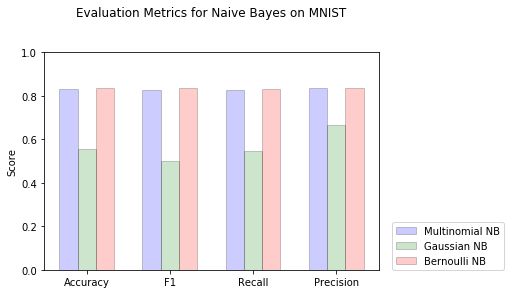

In [34]:
graph_scores([scores_Mult_NB, scores_Gauss_NB, scores_Bern_NB], ['Multinomial NB', 'Gaussian NB', 'Bernoulli NB'], 'Naive Bayes on MNIST')

## Recall vs Precision Graph <a id='recall_precision_graph'></a>

Recall and precision are inversely related, as you increase one the other decreases. Because of this it is often nessicary to adjust the implementation to get the ideal precision or recall for the specific task at hand. A good way to visualize this tradeoff is by graphing recall vs precision at different prediction thresholds. 

In [3]:
# For Scoring and Graph
from sklearn.metrics import average_precision_score, f1_score, precision_score, recall_score, precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
import numpy as np

def graph_precision_recall(target, confidence, title, classes=[]):
    
    if issparse(target):
        target = target.toarray()
    
    # If target is multiclass it must be binarized
    if not np.array_equal(target, target.astype(bool)):
        classes_auto = np.unique(target)
        target = label_binarize(target, classes_auto if len(classes) < len(classes_auto) else classes)

    # A "micro-average": quantifying score on all classes jointly
    precision, recall, threshold = precision_recall_curve(target.ravel(), confidence.ravel())
    average_precision = average_precision_score(target, confidence, average="micro")
    
    # Generate Graph
    plt.figure()
    plt.step(recall, precision, color='b', alpha=0.2,where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(f'Precision-Recall Curve for {title}')
    plt.savefig('./graphs/recall-precision_' + title + '_samples.png')
    plt.show()

    return {'precision': precision, 
            'recall': recall, 
            'threshold': threshold, 
            'average_precision': average_precision }

### Recall-Precision Graph for Naive Bayes with rcv1 <a id='graph_nb_rcv1'></a>

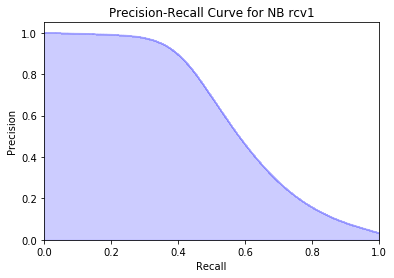

CPU times: user 5min 48s, sys: 18.5 s, total: 6min 6s
Wall time: 6min 5s


In [36]:
%time confidence_NB_rcv1 = clf_NB_rcv1.predict_proba(rcv1_test.data)
metrics_NB_rcv1 = graph_precision_recall(rcv1_test.target, confidence_NB_rcv1, 'NB rcv1' )

### Recall-Precision Graph for for Naive Bayes with MNIST <a id='graph_nb_mnist'></a>

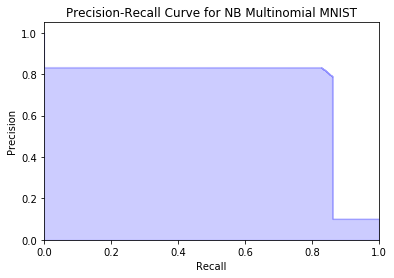

CPU times: user 404 ms, sys: 296 ms, total: 700 ms
Wall time: 332 ms


In [37]:
%time confidence_Mult_NB = clf_Mult_NB.predict_proba(mnist_test.data)
metrics_Mult_NB = graph_precision_recall(mnist_test.target, confidence_Mult_NB, 'NB Multinomial MNIST')

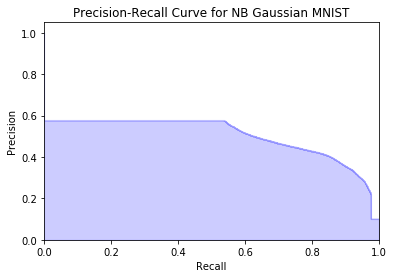

CPU times: user 1.8 s, sys: 740 ms, total: 2.54 s
Wall time: 1.65 s


In [38]:
%time confidence_Gauss_NB = clf_Gauss_NB.predict_proba(mnist_test.data)
metrics_Gauss_NB = graph_precision_recall(mnist_test.target, confidence_Gauss_NB, 'NB Gaussian MNIST' )

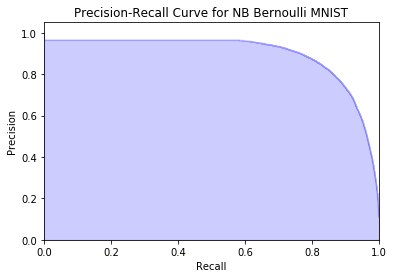

CPU times: user 1.29 s, sys: 712 ms, total: 2 s
Wall time: 1.01 s


In [39]:
%time confidence_Bern_NB = clf_Bern_NB.predict_proba(mnist_test.data)
metrics_Bern_NB = graph_precision_recall(mnist_test.target, confidence_Bern_NB, 'NB Bernoulli MNIST' )

## [K-Folds Cross-Validation](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) <a id='k_folds'></a>

To remove bias from a train/test split it is common practice to use K-Folds cross-validation, typically k = 10. This splits the dataset into k segments. With these k segments k - 1 are used to train a classifier while the last one is used to test. This is repeated until all k segments have been used as the testing segment. 

In [40]:
# For train/test split
from sklearn.model_selection import KFold
from multiprocessing import Process, Manager

def fit_score_thread(clf, X_train, y_train, X_test, y_test, total_scores):
    clf.fit(X_train, y_train)

    # Generate prediction on test data
    prediction = clf.predict(X_test)

    scores = get_scores(y_test, prediction, 'macro')

    for key, score in scores.items():
        total_scores[key] += score

def k_fold_and_score_NB(make_fit_func, data, target, k):
    """ Returns the average scores over k folds.
    
        Params:
          make_fit_func -- a function that takes (data, target) as paramaters
                            and returns a trained classifier
          data -- a [num_samples, num_features] matrix
          target --  a [num_samples, num_labels] matrix
          k -- the number of folds to make """
    
    # Initialize train/test split
    kf = KFold(n_splits=k, shuffle=True, random_state=34)

    # Initialize total score dictionary
    total_scores = Manager().dict()
    for score_type in ['accuracy', 'f1', 'recall', 'precision']:
        total_scores[score_type] = 0.
    
    processes = []
    
    # Iterate over each train/test split
    for train_index, test_index in kf.split(data):
        X_train = data[train_index]
        X_test = data[test_index]
        y_train = target[train_index]
        y_test = target[test_index]

        # Train classifier
        split_clf = make_fit_func()
        
        p = Process(target=fit_score_thread, args=(split_clf, X_train, y_train, X_test, y_test, total_scores))
        p.start()
        
        processes += [p]

    for p in processes:
        p.join()

    avg_scores = {}
    for key, score in total_scores.items():
            avg_scores[key] = score / k

    for _, score in avg_scores.items():
        assert score >= 0.
        assert score <= 1.

    return avg_scores

In [ ]:
from sklearn.naive_bayes import BernoulliNB

%time avg_scores_NB = k_fold_and_score_NB(BernoulliNB, mnist.data, mnist.target, 10)
print_scores(avg_scores_NB, 'macro')

## [Support Vector Machines (SVM)](http://scikit-learn.org/stable/modules/svm.html) <a id='svm'></a>
    
A supervised learning that works by seperating the samples into categories seperated by a hyperplane, or set of hyperplanes. Since the hyperplane that that seperates them is not typically unique SVM finds the hyperplane with the maximum margin between classes[boser-1992]. Support Vector Machines are binary classifiers, but by combining multiple classifiers it can be expanded to fit a multi-class classification problem [wu-2004]. The decision function for a SVM can be found in [boser-1992] eq. (4). Let $\alpha_k$ be the adjustable paramaters (weights), $x_k$ be the patterns for training, $b$ be the bias, and the function $K$ be the kernel function [boser-1992] [guyon-1993].

\begin{equation}
    D(x) = \sum_{k=1}^p \alpha_k K(x_k, x) + b
\end{equation}

SVM use kernel functions to compute the similarity between data points. Some of the most common are:

+ polynomial with order $q$ [boser-1992]
\begin{equation}
    K(x, x') = ( x \cdot x' + 1)^q
\end{equation}
+ radial basis function (rbf) - From eq (9) [guyon-1993]
\begin{equation}
    K(x, x') = \exp \bigg\{ - \frac{\mid \mid x - x_i \mid \mid^2}{\sigma^2} \bigg\}
\end{equation}
+ sigmoid - From eq (2.69) [scholkopf-2009]
\begin{equation}
    K(x, x') = tanh(\kappa \langle x,x' \rangle + \vartheta)
\end{equation}

The kernel used can significantly impact the accuracy of a classifier. More information on kernels is provided [here](http://scikit-learn.org/stable/modules/metrics.html).

### Initialize and Fit for rcv1 <a id='svm_rcv1'></a>

In [41]:
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import BaggingClassifier

clf_SVM_rcv1 = OneVsRestClassifier(BaggingClassifier(LinearSVC()), n_jobs=-1)
%time clf_SVM_rcv1.fit(rcv1_train.data, rcv1_train.target)

/opt/conda/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 49 is present in all training examples.
  str(classes[c]))
/opt/conda/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 80 is present in all training examples.
  str(classes[c]))


CPU times: user 5.68 s, sys: 5.05 s, total: 10.7 s
Wall time: 20 s


Support Vector Machines do not scale well to large datasets because of this additional strategies needed to be implemented to make the RCV1 dataset work. Since RCV1 requires multiple outputs the one-vs-all strategy needed to be implemented. Next a linear kernel was applied, this reduces complexity and memory usage when compared to some of the more complex kernels. The last method used is an ensamble method, specifically the [BaggingClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html). This fits classifiers to random subsets of the origional dataset and combines their predictions.

### Generate Scores for rcv1

In [42]:
%time pred_SVM_rcv1 = clf_SVM_rcv1.predict(rcv1_test.data)

scores_SVM_rcv1 = get_scores(rcv1_test.target, pred_SVM_rcv1, 'micro')
print_scores(scores_SVM_rcv1, 'micro')

### Generate Recall-Precision Graph for rcv1

CPU times: user 32min 43s, sys: 388 ms, total: 32min 43s
Wall time: 32min 48s


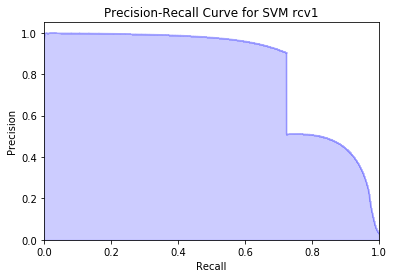

CPU times: user 5min 35s, sys: 18.1 s, total: 5min 53s
Wall time: 5min 52s


In [44]:
%time confidence_SVM_rcv1 = clf_SVM_rcv1.decision_function(rcv1_test.data)
metrics_SVM_rcv1 = graph_precision_recall(rcv1_test.target, confidence_SVM_rcv1, 'SVM rcv1' )

### Initialize and Fit for MNIST <a id='svm_mnist'></a>

In [ ]:
from sklearn.svm import SVC

clf_SVM_mnist = SVC(kernel='rbf')
%time clf_SVM_mnist.fit(mnist_train.data, mnist_train.target)

In [ ]:
from sklearn.svm import SVC

clf_SVM_mnist_2 = SVC(C=1, gamma= .05,kernel='rbf', random_state=35)
%time clf_SVM_mnist_2.fit(mnist_train.data, mnist_train.target)

In [5]:
from sklearn.svm import LinearSVC

clf_SVM_mnist_linear = LinearSVC()
%time clf_SVM_mnist_linear.fit(mnist_train.data, mnist_train.target)

CPU times: user 1min 38s, sys: 100 ms, total: 1min 39s
Wall time: 1min 39s


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

### Generate Scores for MNIST

In [ ]:
%time pred_SVM_mnist = clf_SVM_mnist.predict(mnist_test.data)

scores_SVM_mnist = get_scores(mnist_test.target, pred_SVM_mnist, 'macro')
print_scores(scores_SVM_mnist, 'macro')

In [ ]:
%time pred_SVM_mnist_2 = clf_SVM_mnist_2.predict(mnist_test.data)

scores_SVM_mnist_2 = get_scores(mnist_test.target, pred_SVM_mnist_2, 'macro')
print_scores(scores_SVM_mnist_2, 'macro')

In [9]:
%time pred_SVM_mnist_linear = clf_SVM_mnist_linear.predict(mnist_test.data)

scores_SVM_mnist_linear = get_scores(mnist_test.target, pred_SVM_mnist_linear, 'macro')
print_scores(scores_SVM_mnist_linear, 'macro')

CPU times: user 100 ms, sys: 60 ms, total: 160 ms
Wall time: 157 ms
Accuracy: 0.8669
macro-averaged F1: 0.8676
macro averaged recall: 0.8666
macro averaged precision: 0.8772


### Generate Recall-Precision Graph for MNIST

In [ ]:
%time confidence_SVM_mnist = clf_SVM_mnist.decision_function(mnist_test.data)
metrics_SVM_mnist = graph_precision_recall(mnist_test.target, confidence_SVM_mnist, 'SVM MNIST' )

In [ ]:
%time confidence_SVM_mnist_2 = clf_SVM_mnist_2.decision_function(mnist_test.data)
metrics_SVM_mnist_2 = graph_precision_recall(mnist_test.target, confidence_SVM_mnist_2, 'SVM MNIST C=1 gamma=.5' )

CPU times: user 96 ms, sys: 60 ms, total: 156 ms
Wall time: 164 ms


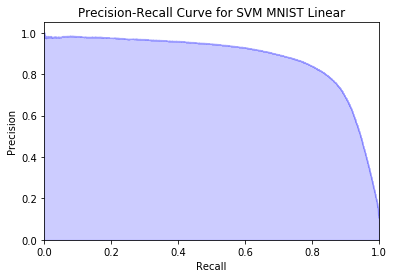

In [12]:
%time confidence_SVM_mnist_linear = clf_SVM_mnist_linear.decision_function(mnist_test.data)
metrics_SVM_mnist_linear = graph_precision_recall(mnist_test.target, confidence_SVM_mnist_linear, 'SVM MNIST Linear' )

## [k-Nearest Neighbors (kNN)](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) <a id='knn'></a>

This algorithm is not trained like the previous machine learning algorithms. Nearest Neighbors is an instance-based learning algorithm, meaning it simply scores the training data instead of making a general model. It works by calculating the distance from a query point to all other points in the training set, and the top k closest points are returned. This can be very computationally demanding so an additional algorithm is typically implemented to help calculate distance. The two most frequently used algorithms are kd-tree and BallTree. Both are considerably faster than calculating neighbors with brute force, and BallTree performs especially well in high dimensions. Note that tree implementations cannot be applied to sparse data.

Additionally the [distince metric](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html) can be tailored to the dataset. Let $n$ be the number of dimensions in $\vec{x}$, and let $x_i$ represent the $i^{\text{th}}$ dimension of $\vec{x}$.

* Euclidean 
\begin{equation*}
dist(\vec{x}, \vec{y}) = \sum_{i=1}^n (x_i - y_i)^2
\end{equation*}
* Manhattan
\begin{equation*}
dist(\vec{x}, \vec{y}) = \sum_{i=1}^n \mid x_i - y_i \mid
\end{equation*}
* Chebyshev
\begin{equation*}
dist(\vec{x}, \vec{y}) = \max_{i \in [1, n]} ( \mid x_i - y_i \mid )
\end{equation*}
* Minkowski
\begin{equation*}
dist(\vec{x}, \vec{y}) = ( \sum_{i=1}^n \mid x_i - y_i \mid^p )^{1/p}
\end{equation*}

Notice Minowski distance is a generalized form of the other distance formulas. When $p = 1$ it is the same as Manhattan distance, when $p = \infty$ it is the same as Chebyshev distance, and when $p = 2$ it is the same as Euclidean distance. The value for $p$ can be any real number.

### Initialize and Fit for rcv1 <a id='knn_rcv1'></a>

In [3]:
# This command changes the location of the temp storage for the notebook needed when running from docker
%env JOBLIB_TEMP_FOLDER=/home/jovyan/work/tmp

env: JOBLIB_TEMP_FOLDER=/home/jovyan/work/tmp


In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier

clf_kNN_rcv1 = OneVsRestClassifier(KNeighborsClassifier(n_jobs=10, algorithm='brute'), n_jobs=10)
%time clf_kNN_rcv1.fit(rcv1_train.data, rcv1_train.target)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 36 µs


/opt/conda/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 49 is present in all training examples.
  str(classes[c]))
/opt/conda/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 80 is present in all training examples.
  str(classes[c]))


CPU times: user 5.72 s, sys: 1.51 s, total: 7.22 s
Wall time: 7.37 s


OneVsRestClassifier(estimator=KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=10, n_neighbors=5, p=2,
           weights='uniform'),
          n_jobs=10)

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier

clf_kNN_rcv1 = KNeighborsClassifier(n_jobs=20, algorithm='brute')
%time clf_kNN_rcv1.fit(rcv1_train.data, rcv1_train.target)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 46 µs
CPU times: user 144 ms, sys: 8 ms, total: 152 ms
Wall time: 152 ms


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=20, n_neighbors=5, p=2,
           weights='uniform')

### Generate Scores for rcv1

In [4]:
%time pred_kNN_rcv1 = clf_kNN_rcv1.predict(rcv1_test.data)

scores_kNN_rcv1 = get_scores(rcv1_test.target, pred_kNN_rcv1, 'micro')
print_scores(scores_kNN_rcv1, 'micro')

### Generate Recall-Precision Graph for rcv1

In [ ]:
%time confidence_kNN_rcv1 = clf_kNN_rcv1.predict_proba(rcv1_test.data)
metrics_kNN_rcv1 = graph_precision_recall(rcv1_test.target, confidence_kNN_rcv1, 'kNN rcv1' )

### Initialize and Fit for MNIST <a id='knn_mnist'></a>

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

clf_kNN_mnist = KNeighborsClassifier(algorithm='ball_tree', p=1, n_jobs=-1)
%time clf_kNN_mnist.fit(mnist_train.data, mnist_train.target)

### Generate Scores for MNIST

In [ ]:
%time pred_kNN_mnist = clf_kNN_mnist.predict(mnist_test.data)

scores_kNN_mnist = get_scores(mnist_test.target, pred_kNN_mnist, 'macro')
print_scores(scores_kNN_mnist, 'macro')

### Generate Recall-Precision Graph for MNIST

In [ ]:
%time confidence_kNN_mnist = clf_kNN_mnist.predict_proba(mnist_test.data)
metrics_kNN_mnist = graph_precision_recall(mnist_test.target, confidence_kNN_mnist, 'kNN MNIST')

## [Decision Trees](http://scikit-learn.org/stable/modules/tree.html) <a id='decision_trees'></a>

Decision Trees form a heirarchy of rules used to classify a document. Decision trees take the form of a tree, as the name suggests. Each node in the tree is a rule and each child node represents a possible outcome. A decision tree is traversed by starting at the root and moving to the appropriate child node based on the current node's rule. This makes decision trees easy to visualize and interpret. 

### Initialize and Fit for rcv1 <a id='dt_rcv1'></a>

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.multiclass import OneVsRestClassifier

clf_DT_rcv1 = OneVsRestClassifier(DecisionTreeClassifier())
%time clf_DT_rcv1.fit(rcv1_train.data, rcv1_train.target)

### Generate Scores for rcv1

In [ ]:
%time pred_DT_rcv1 = clf_DT_rcv1.predict(rcv1_test.data)

scores_DT_rcv1 = get_scores(rcv1_test.target, pred_DT_rcv1, 'micro')
print_scores(scores_DT_rcv1, 'micro')

### Generate Recall-Precision Graph for rcv1

In [ ]:
%time confidence_DT_rcv1 = clf_DT_rcv1.predict_proba(rcv1_test.data)
metrics_DT_rcv1 = graph_precision_recall(rcv1_test.target, confidence_DT_rcv1, 'DT rcv1' )

### Initialize and Fit for MNIST <a id='dt_mnist'></a>

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.multiclass import OneVsRestClassifier

clf_DT_mnist = DecisionTreeClassifier()
%time clf_DT_mnist.fit(mnist_train.data, mnist_train.target)

### Generate Scores for rcv1

In [ ]:
%time pred_DT_mnist = clf_DT_mnist.predict(mnist_test.data)

scores_DT_mnist = get_scores(mnist_test.target, pred_DT_mnist, 'macro')
print_scores(scores_DT_mnist, 'macro')

### Generate Recall-Precision Graph for rcv1

In [ ]:
%time confidence_DT_mnist = clf_DT_mnist.predict_proba(mnist_test.data)
metrics_DT_mnist = graph_precision_recall(mnist_test.target, confidence_DT_mnist, 'DT rcv1' )